In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import sympy as sym
import math

In [2]:
forecastDays=15

In [3]:
#func = lambda x,a,b,c,d,e: a*x**4 + b*x**3 +c*x**2 + d*x + e
func = lambda x,a,b,c,d: a*x**3 + b*x**2 +c*x + d
#func = lambda x,a,b,c: a*x**2 + b*x +c
#func = lambda x,L,k,x0: L/(1.+math.e**(-k*(x-x0)))
#func = lambda x,a,b,c,d: a / (1. + np.exp(-c * (x - d))) + b

In [4]:
values = {
    'Ospedalizzati':'totale_ospedalizzati',
    'Terapia int.':'terapia_intensiva',
    'Deceduti':'deceduti',
         }

In [5]:
data = pd.read_csv('https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
x = np.array(np.linspace(1, len(data), len(data), dtype=float))
xx = np.array(np.linspace(x[0], x[-1]+forecastDays, 50), dtype=float)

y = {k:np.array(data[values[k]], dtype=float) for k in values}
dates = np.array(data['data'])

In [6]:
def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sym.Number)})

In [7]:
def plotCurve(key):
    popt, pcov = sp.optimize.curve_fit(func, x, y[key])
    
    plt.plot(x, y[key], 'ro')
    plt.plot(xx, func(xx, *popt))

    xs = sym.Symbol('x')    
    tex = sym.latex(round_expr(func(xs,*popt), 3)).replace('$', '')
    plt.title('$f(x)= {}$\n{}: {} - {}'.format(tex, key, dates[0], dates[-1]),fontsize=16)

    #plt.title("{}: {} - {}".format(key, dates[0], dates[-1]))
    plt.grid()
    plt.show()

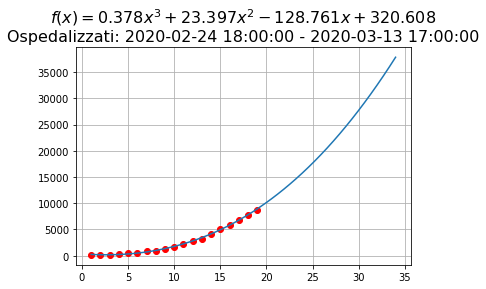

In [8]:
plotCurve('Ospedalizzati')

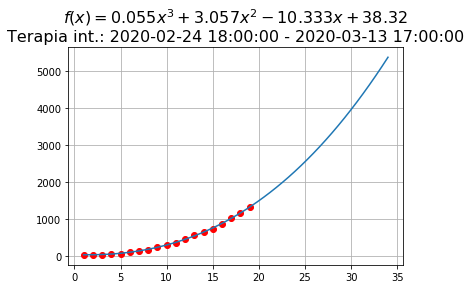

In [9]:
plotCurve('Terapia int.')

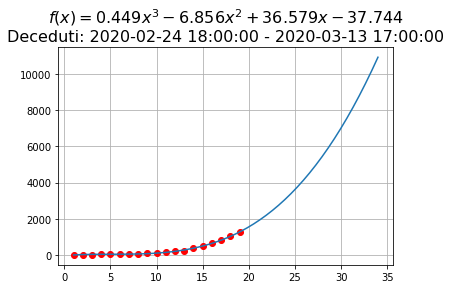

In [10]:
plotCurve('Deceduti')